In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image
import pickle 
import cv2
import torchxrayvision as xrv
import skimage, torch, torchvision
from tqdm import tqdm
from torchvision.transforms import v2
import os

In [2]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [3]:
def get_devices(gpus):
    if len(gpus) == 0:
        device_ids = None
        device = torch.device('cpu')
        print('Warning! Computing on CPU')
    elif len(gpus) == 1:
        device_ids = None
        device = torch.device('cuda:' + str(gpus[0]))
    else:
        device_ids = [int(i) for i in gpus]
        device = torch.device('cuda:' + str(min(device_ids)))
    return device, device_ids

device, device_ids = get_devices([0])

# CXR Disease Classifier based evaluation

In [281]:
pathologies = np.array(["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", 
               "Lesion", "Pneumonia", "Pneumothorax", "No Finding"])

In [282]:
output_mapping = {
    "mimic": [0, 10, 1, 4, 14, 8, 3], 
    "chexpert": [0, 10, 1, 4, 14, 8, 3], 
    "padchest": [0, 10, 1, 4, 8, 3], 
    "nih": [0, 10, 1, 4, 8, 3], 
    "all": [0, 10, 1, 4, 14, 8, 3],
}

def convert_output(model_name, outputs): 
    new_outputs = outputs[:, output_mapping[model_name]]

    if model_name == "padchest" or model_name == "nih": 
        lesion = torch.max(outputs[:, 11], outputs[:, 12])
        new_outputs = torch.hstack((new_outputs[:, :4], lesion.unsqueeze(1), new_outputs[:, 4:]))

    # Append "No Findings" output as last column 
    no_finding_output = outputs[:, [i for i, x in enumerate(model.pathologies) if x != '']]
    # Max probability over all class with positive finding, then take the inverse 
    no_finding = 1. - no_finding_output.max(axis=1)[0]
    new_outputs = torch.hstack((new_outputs, no_finding.unsqueeze(1)))
    return new_outputs

In [283]:
model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.eval()

XRV-DenseNet121-densenet121-res224-all

In [7]:
from diffusers import DiffusionPipeline, UNet2DConditionModel

In [8]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(512), 
                                           torchvision.transforms.ToTensor()])

Setting XRayResizer engine to cv2 could increase performance.


In [111]:
num_images = 10
checkpoints = np.arange(500, 5001, 500)
dataset_name = "mimic"
model_id = "runwayml/stable-diffusion-v1-5"

results = {}
for checkpoint in checkpoints: 
    print("checkpoint {}".format(checkpoint))
    
    file_prefix = f"/mnt/scratch-lids/scratch/qixuanj/cxr_finetune_sd_{dataset_name}_base/checkpoint-{checkpoint}"
    unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet")
    
    pipe = DiffusionPipeline.from_pretrained(model_id, unet=unet, dtype=torch.float16)
    pipe.to("cuda")
 
    all_labels = []
    all_outputs = []
    for i, pathology in enumerate(pathologies): 
        prompt = f"a radiograph from dataset {dataset_name} with conditions {pathology}"
        images = pipe(prompt=prompt, 
                      strength=0.9, guidance_scale=7.5, num_inference_steps=50, 
                      num_images_per_prompt=num_images).images
        images_t = []
        for image in images: 
            image = xrv.utils.normalize(np.array(image), maxval=255, reshape=True)
            images_t.append(transform(image))
        images_t = torch.stack(images_t)
        images_t = torch.permute(images_t, (0, 2, 1, 3))
        with torch.no_grad():
            outputs = model(images_t)
        outputs = convert_output("all", outputs)
        
        labels = np.zeros((num_images, 8))
        labels[:, i] = 1
    
        all_outputs.append(np.array(outputs))
        all_labels.append(labels)
    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)
    
    results[checkpoint] = {}
    auc = roc_auc_score(all_labels, all_outputs)
    task_aucs = roc_auc_score(all_labels, all_outputs, average=None)
    
    results[checkpoint]['auc'] = auc
    results[checkpoint]['task_aucs'] = task_aucs
    results[checkpoint]['task_outputs'] = all_outputs
    results[checkpoint]['task_targets'] = all_labels

checkpoint 500


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.47it/s]


checkpoint 1000


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.47it/s]


checkpoint 1500


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.47it/s]


checkpoint 2000


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.47it/s]


checkpoint 2500


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.47it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.45s/it]


checkpoint 3000


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.50s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.50s/it]


checkpoint 3500


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.29s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.28s/it]


checkpoint 4000


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.19it/s]


checkpoint 4500


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]


checkpoint 5000


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.27it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]


In [112]:
with open(f"/mnt/scratch-lids/scratch/qixuanj/cxr_finetune_sd_{dataset_name}_base/eval_checkpoints_densenet121-res224-all.pkl", "wb") as f: 
    pickle.dump(results, f)cd 

In [118]:
plot_aucs = [results[c]['auc'] for c in checkpoints]

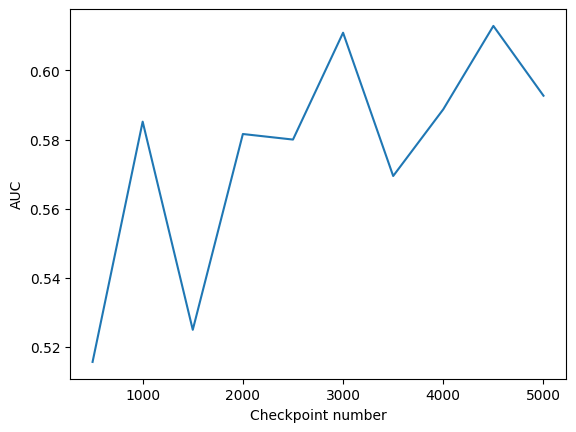

In [120]:
plt.plot(checkpoints, plot_aucs)
plt.xlabel("Checkpoint number")
plt.ylabel("AUC")
plt.savefig(f"/mnt/scratch-lids/scratch/qixuanj/cxr_finetune_sd_{dataset_name}_base/figs/checkpoint_aucs.png", dpi=200)
plt.show()

In [ ]:
# For individual checkpoint

In [17]:
num_images = 10 
all_labels = []
all_outputs = []
for i, pathology in enumerate(pathologies): 
    prompt = f"a radiograph from dataset {dataset_name} with conditions {pathology}"
    images = pipe(prompt=prompt, 
                  strength=0.9, guidance_scale=7.5, num_inference_steps=50, 
                  num_images_per_prompt=num_images).images
    images_t = []
    for image in images: 
        image = np.array(image)
        image = xrv.utils.normalize(image, maxval=255, reshape=True)
        images_t.append(transform(image))
    images_t = torch.stack(images_t)
    images_t = torch.permute(images_t, (0, 2, 1, 3))
    with torch.no_grad():
        outputs = model(images_t)
    outputs = convert_output("all", outputs)
    
    labels = np.zeros((num_images, 8))
    labels[:, i] = 1

    all_outputs.append(np.array(outputs))
    all_labels.append(labels)
all_outputs = np.concatenate(all_outputs)
all_labels = np.concatenate(all_labels)

NameError: name 'pathologies' is not defined

In [98]:
auc = roc_auc_score(all_labels, all_outputs)
print(auc)

0.5669642857142858


In [97]:
task_aucs = pd.DataFrame(roc_auc_score(all_labels, all_outputs, average=None), index=pathologies)
task_aucs

,0
Atelectasis,0.535714
Cardiomegaly,0.857143
Consolidation,0.142857
Edema,0.357143
Lesion,0.535714
Pneumonia,0.785714
Pneumothorax,0.392857
No Finding,0.928571


In [105]:
all_outputs_binary = all_outputs.copy()
all_outputs_binary[all_outputs_binary > 0.5] = 1
all_outputs_binary[all_outputs_binary <= 0.5] = 0

In [107]:
accuracy_score(all_labels, all_outputs_binary)

0.0

# CXR Cross Dataset Classifier based evaluation

In [15]:
from diffusers import DiffusionPipeline, UNet2DConditionModel
from torcheval.metrics import MulticlassAUROC, MulticlassAccuracy

In [5]:
oracle = torch.load("cxr_domain_classify/model.pt")

In [6]:
oracle.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
label_mapping = {'mimic': 0, 'chexpert': 1, 'padchest': 2, 'nih': 3}

In [ ]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224),
                                            v2.ToDtype(torch.float32, scale=True),
                                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                                            ])

In [ ]:
from torch.utils.data import Dataset, DataLoader
class CXRDomain(Dataset):
    def __init__(self, file_path, split, transform=None):
        self.file_path = file_path 
        self.split = split 
        self.transform = transform 
        with open(self.file_path, "rb") as f: 
            prompt_files = pickle.load(f) 
        df = pd.concat([prompt_files['mimic'][split], prompt_files['chexpert'][split], 
                        prompt_files['padchest'][split], prompt_files['nih'][split]]).reset_index(drop=True)
        self.label_mapping = {'mimic': 0, 'chexpert': 1, 'padchest': 2, 'nih': 3}
        df['dataset_label'] = df['dataset_name'].map(self.label_mapping)
        self.df = df
        
    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx): 
        img_dirs = {"mimic": "/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files", 
                    "padchest": "/data/healthy-ml/gobi1/data/PadChest/images-224", 
                    "chexpert": "/data/healthy-ml/gobi1/data", 
                    "nih": "/data/healthy-ml/gobi1/data/ChestXray8/images"}
        
        sample = self.df.iloc[idx]
        img = cv2.imread(img_dirs[sample['dataset_name']] + "/" + sample['file_suffix'])
        if self.transform: 
            img = self.transform(img) 
        return {'img': img, 'label': sample['dataset_label']}

In [ ]:
test_ds = CXRDomain("cxr_prompt_files_base10000.pkl", "test", transform)
test_dataloader = DataLoader(test_ds, batch_size=16, shuffle=False)

In [ ]:
oracle.eval()
avg_loss = []
task_outputs = []
task_targets = []
t = tqdm(test_dataloader)
for batch_idx, sample in enumerate(t): 
    images, targets = sample['img'], sample['label']
    images = torch.cat((images, images, images), 1)
    images = images.to("cuda")
    targets = targets.to("cuda")
    with torch.no_grad():
        outputs = oracle(images)

    task_outputs.append(outputs.detach().cpu().numpy())
    task_targets.append(targets.detach().cpu().numpy())
    
task_outputs = np.concatenate(task_outputs)
task_targets = np.concatenate(task_targets)
auc = MulticlassAUROC(num_classes=4)
auc.update(torch.Tensor(task_outputs), torch.Tensor(task_targets))
auc_result = auc.compute()
print(auc_result)

In [12]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224),
                                            v2.ToDtype(torch.float32, scale=True),
                                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                                            ])

Setting XRayResizer engine to cv2 could increase performance.


In [8]:
from torch.utils.data import Dataset, DataLoader
class CXRDomain(Dataset):
    def __init__(self, file_path, split, transform=None):
        self.file_path = file_path 
        self.split = split 
        self.transform = transform 
        with open(self.file_path, "rb") as f: 
            prompt_files = pickle.load(f) 
        df = pd.concat([prompt_files['mimic'][split], prompt_files['chexpert'][split], 
                        prompt_files['padchest'][split], prompt_files['nih'][split]]).reset_index(drop=True)
        self.label_mapping = {'mimic': 0, 'chexpert': 1, 'padchest': 2, 'nih': 3}
        df['dataset_label'] = df['dataset_name'].map(self.label_mapping)
        self.df = df
        
    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx): 
        img_dirs = {"mimic": "/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files", 
                    "padchest": "/data/healthy-ml/gobi1/data/PadChest/images-224", 
                    "chexpert": "/data/healthy-ml/gobi1/data", 
                    "nih": "/data/healthy-ml/gobi1/data/ChestXray8/images"}
        
        sample = self.df.iloc[idx]
        img = cv2.imread(img_dirs[sample['dataset_name']] + "/" + sample['file_suffix'])
        if self.transform: 
            img = self.transform(img) 
        return {'img': img, 'label': sample['dataset_label']}

In [13]:
test_ds = CXRDomain("cxr_prompt_files_base10000.pkl", "test", transform)
test_dataloader = DataLoader(test_ds, batch_size=16, shuffle=False)

In [196]:
oracle.eval()
avg_loss = []
task_outputs = []
task_targets = []
t = tqdm(test_dataloader)
for batch_idx, sample in enumerate(t): 
    images, targets = sample['img'], sample['label']
    images = torch.cat((images, images, images), 1)
    images = images.to("cuda")
    targets = targets.to("cuda")
    with torch.no_grad():
        outputs = oracle(images)

    task_outputs.append(outputs.detach().cpu().numpy())
    task_targets.append(targets.detach().cpu().numpy())
    
task_outputs = np.concatenate(task_outputs)
task_targets = np.concatenate(task_targets)
auc = MulticlassAUROC(num_classes=4)
auc.update(torch.Tensor(task_outputs), torch.Tensor(task_targets))
auc_result = auc.compute()
print(auc_result)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2465/2465 [2:05:00<00:00,  3.04s/it]

tensor(0.8504)


## Run

In [17]:
num_images = 10
checkpoints = np.arange(200, 1001, 200)
model_id = "runwayml/stable-diffusion-v1-5"

keyword = "cxr_transfer_sd_mimic_nih_1000_balanced"
condition_prompts = ["Cardiomegaly, Pneumonia", "No Findings"]

results = {}
for checkpoint in checkpoints:
    results[checkpoint] = {}
    print("checkpoint {}".format(checkpoint))
    
    file_prefix = f"/mnt/scratch-lids/scratch/qixuanj/{keyword}/checkpoint-{checkpoint}"
    unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet")
    
    pipe = DiffusionPipeline.from_pretrained(model_id, unet=unet, dtype=torch.float16, safety_checker=None)
    pipe.to("cuda")

    source_dataset = keyword.split("_")[3]
    target_dataset = keyword.split("_")[4]


    # Source 
    all_labels = []
    all_outputs = []
    for i, condition in enumerate(condition_prompts): 
        prompt = f"a radiograph from dataset {source_dataset} with conditions {condition}"
        images = pipe(prompt=prompt, 
                      strength=0.9, guidance_scale=7.5, num_inference_steps=30, 
                      num_images_per_prompt=num_images).images
        images_t = []
        for image in images: 
            image = torch.Tensor(transform(np.array(image)))
            image = torch.cat((image, image, image), 0)
            images_t.append(image)
        images_t = torch.stack(images_t)
        images_t = images_t.to("cuda")
        
        with torch.no_grad():
            outputs = oracle(images_t)
        
        labels = np.repeat(label_mapping[source_dataset], num_images)
    
        all_outputs.append(outputs.detach().cpu().numpy())
        all_labels.append(labels)
    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)
    
    # auc = MulticlassAUROC(num_classes=4)
    # auc.update(torch.Tensor(all_outputs), torch.Tensor(all_labels))
    # source_auc_result = auc.compute()
    
    acc = MulticlassAccuracy()
    acc.update(torch.Tensor(all_outputs), torch.Tensor(all_labels))
    source_auc_result = acc.compute().item()
    
    # Target 
    all_labels = []
    all_outputs = []
    for i, condition in enumerate(condition_prompts): 
        prompt = f"a radiograph from dataset {target_dataset} with conditions {condition}"
        images = pipe(prompt=prompt, 
                      strength=0.9, guidance_scale=7.5, num_inference_steps=30, 
                      num_images_per_prompt=num_images).images
        images_t = []
        for image in images: 
            image = torch.Tensor(transform(np.array(image)))
            image = torch.cat((image, image, image), 0)
            images_t.append(image)
        images_t = torch.stack(images_t)
        images_t = images_t.to("cuda")
        
        with torch.no_grad():
            outputs = oracle(images_t)
        
        labels = np.repeat(label_mapping[target_dataset], num_images)
    
        all_outputs.append(outputs.detach().cpu().numpy())
        all_labels.append(labels)
    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)
    
    # auc = MulticlassAUROC(num_classes=4)
    # auc.update(torch.Tensor(all_outputs), torch.Tensor(all_labels))
    # target_auc_result = auc.compute()

    acc = MulticlassAccuracy()
    acc.update(torch.Tensor(all_outputs), torch.Tensor(all_labels))
    target_auc_result = acc.compute().item()

    results[checkpoint]['source_acc'] = source_auc_result
    results[checkpoint]['target_acc'] = target_auc_result
    print(source_auc_result) 
    print(target_auc_result)
    
result_dir = f"/mnt/scratch-lids/scratch/qixuanj/{keyword}/eval"
if not os.path.exists(result_dir): 
    os.makedirs(result_dir)
with open(result_dir + "/checkpoint_oracle_acc.pkl", "wb") as f: 
    pickle.dump(results, f) 

checkpoint 200


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.81it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.80it/s]


tensor(0.3000)
tensor(0.4000)
checkpoint 400


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.80it/s]


tensor(0.1000)
tensor(0.4000)
checkpoint 600


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.81it/s]


tensor(0.1000)
tensor(0.1000)
checkpoint 800


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.81it/s]


tensor(0.1000)
tensor(0.1000)
checkpoint 1000


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.80it/s]


tensor(0.1000)
tensor(0.6000)


In [184]:
# Benchmark baseline model 

num_images = 10
checkpoints = [4500]
model_id = "runwayml/stable-diffusion-v1-5"

keyword = "cxr_finetune_sd_chexpert_base"
condition_prompts = ["Cardiomegaly, Pneumonia", "No Findings"]

results = {}
for checkpoint in checkpoints:
    results[checkpoint] = {}
    print("checkpoint {}".format(checkpoint))
    
    file_prefix = f"/mnt/scratch-lids/scratch/qixuanj/{keyword}/checkpoint-{checkpoint}"
    unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet")
    
    pipe = DiffusionPipeline.from_pretrained(model_id, unet=unet, dtype=torch.float16)
    pipe.to("cuda")

    source_dataset = keyword.split("_")[3]

    # Source 
    all_labels = []
    all_outputs = []
    for i, condition in enumerate(condition_prompts): 
        prompt = f"a radiograph from dataset {source_dataset} with conditions {condition}"
        images = pipe(prompt=prompt, 
                      strength=0.9, guidance_scale=7.5, num_inference_steps=30, 
                      num_images_per_prompt=num_images).images
        images_t = []
        for image in images: 
            image = torch.Tensor(transform(np.array(image)))
            image = torch.cat((image, image, image), 0)
            images_t.append(image)
        images_t = torch.stack(images_t)
        images_t = images_t.to("cuda")
        
        with torch.no_grad():
            outputs = oracle(images_t)
        
        labels = np.repeat(label_mapping[source_dataset], num_images)
    
        all_outputs.append(outputs.detach().cpu().numpy())
        all_labels.append(labels)
    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)
    
    auc = MulticlassAUROC(num_classes=4)
    auc.update(torch.Tensor(all_outputs), torch.Tensor(all_labels))
    source_auc_result = auc.compute()

    results[checkpoint]['source_auc'] = source_auc_result
    print(source_auc_result) 
    break

checkpoint 4500


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.48it/s]


tensor(0.5000)


# Waterbirds Classifier evaluation

In [264]:
from torcheval.metrics import BinaryAUROC, BinaryAccuracy, MulticlassAccuracy

In [30]:
model = torch.load("waterbirds_results/oracle/model.pt")

In [31]:
model.to("cuda")
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [267]:
from diffusers import StableDiffusionPipeline
from diffusers import DiffusionPipeline, UNet2DConditionModel

In [36]:
# y = 0 (landbird), y = 1 (waterbird)
transform = torchvision.transforms.Compose([v2.CenterCrop(224),
                                            v2.RandomHorizontalFlip(),
                                            v2.ToTensor(),
                                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                                            ])
sigmoid = torch.nn.Sigmoid()

In [269]:
model_id = "runwayml/stable-diffusion-v1-5"
checkpoints = np.arange(200, 2001, 200)

checkpoint_results = {}
for checkpoint in checkpoints: 
    file_prefix = f"/mnt/scratch-lids/scratch/qixuanj/waterbirds_finetune_sd_base/checkpoint-{checkpoint}"
    unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet")
    
    pipe = DiffusionPipeline.from_pretrained(model_id, unet=unet, dtype=torch.bfloat16, safety_checker=None,)
    pipe.to("cuda")
    
    num_images = 10
    prompts = [
        "a photo of landbird with background of <wb-source-domain>", 
        "a photo of waterbird with background of <wb-source-domain>",
        "a photo of landbird with background of blue ocean or lake",
        "a photo of waterbird with background of green bamboo forest",
        "a photo of waterbird with background of blue ocean or lake",
        "a photo of landbird with background of green bamboo forest",
    ]

    acc_results = []
    for i, p in enumerate(prompts): 
        images = pipe(prompt=p, 
                      strength=0.9, guidance_scale=7.5, num_inference_steps=50, 
                      num_images_per_prompt=num_images).images
        images_t = []
        for image in images: 
            images_t.append(transform(image).to("cuda"))
        images_t = torch.stack(images_t)
        outputs = model(images_t).detach().cpu().squeeze()
        outputs = sigmoid(outputs)
        if "landbird" in p: 
            targets = torch.full(outputs.size(), 0)
        elif "waterbird" in p: 
            targets = torch.full(outputs.size(), 1)

        acc = BinaryAccuracy()
        acc.update(outputs, targets)
        acc_results.append(acc.compute())
    print(acc_results)
    print(np.mean(np.array(acc_results)))
    checkpoint_results[checkpoint] = acc_results
with open(f"/mnt/scratch-lids/scratch/qixuanj/waterbirds_finetune_sd_base/checkpoint_results2.pkl", "wb") as f: 
    pickle.dump(checkpoint_results, f) 
for checkpoint, result in checkpoint_results.items(): 
    result = [x.item() for x in result]
    print(f"checkpoint {checkpoint}: {round(np.mean(np.array(result)), 3)}")

Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.88it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.9000), tensor(0.5000), tensor(0.5000), tensor(0.1000), tensor(0.5000), tensor(0.9000)]
0.56666666


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.9000), tensor(0.6000), tensor(0.8000), tensor(0.5000), tensor(0.1000), tensor(1.)]
0.65


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.8000), tensor(0.6000), tensor(0.6000), tensor(0.4000), tensor(0.4000), tensor(1.)]
0.6333334


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.54it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.9000), tensor(0.6000), tensor(0.8000), tensor(0.3000), tensor(0.1000), tensor(1.)]
0.6166666


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.81it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(1.), tensor(0.4000), tensor(0.8000), tensor(0.1000), tensor(0.3000), tensor(1.)]
0.59999996


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(1.), tensor(0.6000), tensor(0.9000), tensor(0.5000), tensor(0.6000), tensor(1.)]
0.76666665


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(1.), tensor(0.7000), tensor(0.8000), tensor(0.3000), tensor(0.4000), tensor(1.)]
0.7


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(1.), tensor(0.4000), tensor(0.9000), tensor(0.4000), tensor(0.7000), tensor(1.)]
0.73333335


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.52it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(1.), tensor(0.5000), tensor(0.9000), tensor(0.5000), tensor(0.2000), tensor(0.9000)]
0.6666667


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.60it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.8000), tensor(1.), tensor(0.9000), tensor(0.2000), tensor(0.6000), tensor(1.)]
0.75


In [271]:
for checkpoint, result in checkpoint_results.items(): 
    result = [x.item() for x in result]
    print(f"checkpoint {checkpoint}: {round(np.mean(np.array(result)), 3)}")

checkpoint 200: 0.567
checkpoint 400: 0.65
checkpoint 600: 0.633
checkpoint 800: 0.617
checkpoint 1000: 0.6
checkpoint 1200: 0.767
checkpoint 1400: 0.7
checkpoint 1600: 0.733
checkpoint 1800: 0.667
checkpoint 2000: 0.75


In [ ]:
keywords = [
    "waterbirds_finetune_sd_transfer_10",
    "waterbirds_finetune_sd_transfer_50",
    "waterbirds_finetune_sd_transfer_100",
    "waterbirds_finetune_sd_transfer_500",
    "waterbirds_finetune_sd_transfer_816",
           ]

for keyword in keywords: 
    model_id = "runwayml/stable-diffusion-v1-5"
    checkpoints = np.arange(200, 2001, 200)
    
    checkpoint_results = {}
    for checkpoint in checkpoints: 
        file_prefix = f"/mnt/scratch-lids/scratch/qixuanj/{keyword}/checkpoint-{checkpoint}"
        unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet")
        
        pipe = DiffusionPipeline.from_pretrained(model_id, unet=unet, dtype=torch.bfloat16, safety_checker=None,)
        pipe.to("cuda")
        
        num_images = 10
        prompts = [
            "a photo of landbird with background of <wb-source-domain>", 
            "a photo of waterbird with background of <wb-source-domain>",
            "a photo of landbird with background of <wb-target-domain>", 
            "a photo of waterbird with background of <wb-target-domain>",
            "a photo of landbird with background of blue ocean or lake",
            "a photo of waterbird with background of green bamboo forest",
            "a photo of waterbird with background of blue ocean or lake",
            "a photo of landbird with background of green bamboo forest",
        ]
    
        acc_results = []
        for i, p in enumerate(prompts): 
            images = pipe(prompt=p, 
                          strength=0.9, guidance_scale=7.5, num_inference_steps=50, 
                          num_images_per_prompt=num_images).images
            images_t = []
            for image in images: 
                images_t.append(transform(image).to("cuda"))
            images_t = torch.stack(images_t)
            outputs = model(images_t).detach().cpu().squeeze()
            outputs = sigmoid(outputs)
            if "landbird" in p: 
                targets = torch.full(outputs.size(), 0)
            elif "waterbird" in p: 
                targets = torch.full(outputs.size(), 1)
    
            acc = BinaryAccuracy()
            acc.update(outputs, targets)
            acc_results.append(acc.compute())
        print(acc_results)
        print(np.mean(np.array(acc_results)))
        checkpoint_results[checkpoint] = acc_results
    with open(f"/mnt/scratch-lids/scratch/qixuanj/{keyword}/checkpoint_results.pkl", "wb") as f: 
        pickle.dump(checkpoint_results, f) 
    for checkpoint, result in checkpoint_results.items(): 
        result = [x.item() for x in result]
        print(f"checkpoint {checkpoint}: {round(np.mean(np.array(result)), 3)}")

## Oracle for only bird species

In [32]:
# Oracle model for individual class 
with open("waterbirds_results/oracle_group/val_aucs.pkl", "rb") as f: 
    val_aucs = pickle.load(f)
val_aucs = [x.item() for x in val_aucs]
epochs_map = np.arange(10, 101, 10)
checkpoint = str(epochs_map[np.argmax(np.array(val_aucs))])

In [33]:
checkpoint

'90'

In [34]:
# Oracle model for individual class 
model = torch.load(f"waterbirds_results/oracle_group/checkpoint{checkpoint}.pt")
model.to("cuda")
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [275]:
model_id = "runwayml/stable-diffusion-v1-5"
checkpoints = np.arange(200, 2001, 200)
num_images = 10

checkpoint_results = {}
for checkpoint in checkpoints: 
    file_prefix = f"/mnt/scratch-lids/scratch/qixuanj/waterbirds_finetune_sd_base/checkpoint-{checkpoint}"
    unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet")
    pipe = DiffusionPipeline.from_pretrained(model_id, unet=unet, dtype=torch.bfloat16, safety_checker=None,)
    pipe.to("cuda")
    
    prompts = [
        "a photo of landbird with background of <wb-source-domain>", 
        "a photo of waterbird with background of <wb-source-domain>",
        "a photo of landbird with background of blue ocean or lake",
        "a photo of waterbird with background of green bamboo forest",
        "a photo of waterbird with background of blue ocean or lake",
        "a photo of landbird with background of green bamboo forest",
    ]

    acc_results = []
    for i, p in enumerate(prompts): 
        images = pipe(prompt=p, 
                      strength=0.9, guidance_scale=7.5, num_inference_steps=50, 
                      num_images_per_prompt=num_images).images
        images_t = []
        for image in images: 
            images_t.append(transform(image).to("cuda"))
        images_t = torch.stack(images_t)
        outputs = model(images_t).detach().cpu().squeeze()
        outputs = sigmoid(outputs)
        if "landbird" in p and "<wb-source-domain>" in p: 
            targets = torch.full((num_images, 1), 0).squeeze()
        elif "landbird" in p and "forest" in p: 
            targets = torch.full((num_images, 1), 0).squeeze()
        elif "landbird" in p and "ocean" in p: 
            targets = torch.full((num_images, 1), 1).squeeze()
        elif "waterbird" in p and "<wb-source-domain>" in p: 
            targets = torch.full((num_images, 1), 3).squeeze()
        elif "waterbird" in p and "ocean" in p: 
            targets = torch.full((num_images, 1), 3).squeeze()
        elif "waterbird" in p and "forest" in p: 
            targets = torch.full((num_images, 1), 2).squeeze()

        acc = MulticlassAccuracy()
        acc.update(outputs, targets)
        acc_results.append(acc.compute())
    print(acc_results)
    print(np.mean(np.array(acc_results)))
    checkpoint_results[checkpoint] = acc_results
with open(f"/mnt/scratch-lids/scratch/qixuanj/waterbirds_finetune_sd_base/checkpoint_group_results2.pkl", "wb") as f: 
    pickle.dump(checkpoint_results, f) 
for checkpoint, result in checkpoint_results.items(): 
    result = [x.item() for x in result]
    print(f"checkpoint {checkpoint}: {round(np.mean(np.array(result)), 3)}")

Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.3000), tensor(0.9000), tensor(0.), tensor(0.), tensor(0.2000), tensor(1.)]
0.4


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.79it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.6000), tensor(0.7000), tensor(0.), tensor(0.), tensor(0.2000), tensor(0.9000)]
0.4


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.69it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.9000), tensor(0.7000), tensor(0.), tensor(0.), tensor(0.6000), tensor(0.9000)]
0.51666665


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.65it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.8000), tensor(0.3000), tensor(0.), tensor(0.), tensor(0.2000), tensor(1.)]
0.38333336


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.70it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.8000), tensor(0.3000), tensor(0.), tensor(0.), tensor(0.7000), tensor(0.8000)]
0.4333333


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.56it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.9000), tensor(0.5000), tensor(0.), tensor(0.), tensor(0.3000), tensor(1.)]
0.45000002


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.66it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.8000), tensor(0.5000), tensor(0.), tensor(0.), tensor(0.1000), tensor(1.)]
0.4


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.29it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.9000), tensor(0.5000), tensor(0.1000), tensor(0.), tensor(0.3000), tensor(1.)]
0.46666667


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.63it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.9000), tensor(0.5000), tensor(0.), tensor(0.1000), tensor(0.4000), tensor(0.9000)]
0.46666667


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.62it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|███████████████████████████████████████████████████████████████████████████████████████████

[tensor(0.7000), tensor(0.6000), tensor(0.), tensor(0.), tensor(0.5000), tensor(0.9000)]
0.44999996


In [38]:
keywords = [
    "waterbirds_finetune_sd_transfer_10",
    "waterbirds_finetune_sd_transfer_50",
    "waterbirds_finetune_sd_transfer_100",
    "waterbirds_finetune_sd_transfer_500",
    "waterbirds_finetune_sd_transfer_816",
           ]

model_id = "runwayml/stable-diffusion-v1-5"
checkpoints = np.arange(200, 2001, 200)
num_images = 10

for keyword in keywords:
    checkpoint_results = {}
    for checkpoint in checkpoints: 
        file_prefix = f"/mnt/scratch-lids/scratch/qixuanj/{keyword}/checkpoint-{checkpoint}"
        unet = UNet2DConditionModel.from_pretrained(f"{file_prefix}/unet")
        pipe = DiffusionPipeline.from_pretrained(model_id, unet=unet, dtype=torch.bfloat16, safety_checker=None,)
        pipe.to("cuda")
        
        prompts = [
            "a photo of landbird with background of <wb-source-domain>", 
            "a photo of waterbird with background of <wb-source-domain>",
            "a photo of landbird with background of <wb-target-domain>", 
            "a photo of waterbird with background of <wb-target-domain>",
            # "a photo of landbird with background of blue ocean or lake",
            # "a photo of waterbird with background of green bamboo forest",
            # "a photo of waterbird with background of blue ocean or lake",
            # "a photo of landbird with background of green bamboo forest",
        ]
    
        acc_results = []
        for i, p in enumerate(prompts): 
            images = pipe(prompt=p, 
                          strength=0.9, guidance_scale=7.5, num_inference_steps=50, 
                          num_images_per_prompt=num_images).images
            images_t = []
            for image in images: 
                images_t.append(transform(image).to("cuda"))
            images_t = torch.stack(images_t)
            outputs = model(images_t).detach().cpu().squeeze()
            outputs = sigmoid(outputs)
            if "landbird" in p and "<wb-source-domain>" in p: 
                targets = torch.full((num_images, 1), 0).squeeze()
            elif "landbird" in p and "<wb-target-domain>" in p: 
                targets = torch.full((num_images, 1), 1).squeeze()
            elif "landbird" in p and "forest" in p: 
                targets = torch.full((num_images, 1), 0).squeeze()
            elif "landbird" in p and "ocean" in p: 
                targets = torch.full((num_images, 1), 1).squeeze()
            elif "waterbird" in p and "<wb-source-domain>" in p: 
                targets = torch.full((num_images, 1), 3).squeeze()
            elif "waterbird" in p and "<wb-target-domain>" in p: 
                targets = torch.full((num_images, 1), 2).squeeze()
            elif "waterbird" in p and "ocean" in p: 
                targets = torch.full((num_images, 1), 3).squeeze()
            elif "waterbird" in p and "forest" in p: 
                targets = torch.full((num_images, 1), 2).squeeze()
    
            acc = MulticlassAccuracy()
            acc.update(outputs, targets)
            acc_results.append(acc.compute())
        print(acc_results)
        print(np.mean(np.array(acc_results)))
        checkpoint_results[checkpoint] = acc_results
    with open(f"/mnt/scratch-lids/scratch/qixuanj/{keyword}/checkpoint_group_results2.pkl", "wb") as f: 
        pickle.dump(checkpoint_results, f) 

    print(keyword)
    for checkpoint, result in checkpoint_results.items():
        result = [x.item() for x in result]
        print(f"checkpoint {checkpoint}: {round(np.mean(np.array(result)), 3)}")

Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.42it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


KeyboardInterrupt: 

In [276]:
with open(f"/mnt/scratch-lids/scratch/qixuanj/waterbirds_finetune_sd_base/checkpoint_group_results2.pkl", "wb") as f: 
    pickle.dump(checkpoint_results, f) 

In [277]:
for checkpoint, result in checkpoint_results.items(): 
    result = [x.item() for x in result]
    print(f"checkpoint {checkpoint}: {round(np.mean(np.array(result)), 3)}")

checkpoint 200: 0.4
checkpoint 400: 0.4
checkpoint 600: 0.517
checkpoint 800: 0.383
checkpoint 1000: 0.433
checkpoint 1200: 0.45
checkpoint 1400: 0.4
checkpoint 1600: 0.467
checkpoint 1800: 0.467
checkpoint 2000: 0.45
